In [13]:
import os
import rasterio
import numpy as np
import uuid
import numpy as np
from rasterio.windows import from_bounds
from glob import glob
from utils import check_band_coverage, read_pansharpened_tiff, pansharpen_to_10m_and_save, RandomApplyTransform, RandomRadiometricShift
import random
import shutil
import random
import torch
import torchvision.transforms as T
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np


### Pansharpening

In [4]:
check_band_coverage("data/S2A_MSIL1C_20210925T092031_N0500_R093_T34SEJ_20230118T233535.SAFE/GRANULE/L1C_T34SEJ_A032694_20210925T092343/IMG_DATA")
check_band_coverage("data/S2A_MSIL1C_20210925T092031_N0500_R093_T34SFJ_20230118T233535.SAFE/GRANULE/L1C_T34SFJ_A032694_20210925T092343/IMG_DATA")
check_band_coverage("data/S2A_MSIL1C_20210925T092031_N0500_R093_T34TEK_20230118T233535.SAFE/GRANULE/L1C_T34TEK_A032694_20210925T092343/IMG_DATA")
check_band_coverage("data/S2A_MSIL1C_20210925T092031_N0500_R093_T34TFK_20230118T233535.SAFE/GRANULE/L1C_T34TFK_A032694_20210925T092343/IMG_DATA")


 L1C_T34SEJ_A032694_20210925T092343

Band   Resolution Shape           Valid Pixels (%)  
------------------------------------------------------------
B01    60.0       (1830, 1830)    100.00            
B02    10.0       (10980, 10980)  100.00            
B03    10.0       (10980, 10980)  100.00            
B04    10.0       (10980, 10980)  100.00            
B05    20.0       (5490, 5490)    100.00            
B06    20.0       (5490, 5490)    100.00            
B07    20.0       (5490, 5490)    100.00            
B08    10.0       (10980, 10980)  100.00            
B09    60.0       (1830, 1830)    100.00            
B10    60.0       (1830, 1830)    100.00            
B11    20.0       (5490, 5490)    100.00            
B12    20.0       (5490, 5490)    100.00            
B8A    20.0       (5490, 5490)    100.00            

 L1C_T34SFJ_A032694_20210925T092343

Band   Resolution Shape           Valid Pixels (%)  
------------------------------------------------------------
B01    

In [3]:
pansharpen_to_10m_and_save("data/S2A_MSIL1C_20210925T092031_N0500_R093_T34SEJ_20230118T233535.SAFE/GRANULE/L1C_T34SEJ_A032694_20210925T092343/IMG_DATA", output_tiff="data/T34SEJ_pansharpened.tif")
pansharpen_to_10m_and_save("data/S2A_MSIL1C_20210925T092031_N0500_R093_T34SFJ_20230118T233535.SAFE/GRANULE/L1C_T34SFJ_A032694_20210925T092343/IMG_DATA", output_tiff="data/T34SFJ_pansharpened.tif")
pansharpen_to_10m_and_save("data/S2A_MSIL1C_20210925T092031_N0500_R093_T34TEK_20230118T233535.SAFE/GRANULE/L1C_T34TEK_A032694_20210925T092343/IMG_DATA", output_tiff="data/T34TEK_pansharpened.tif")
pansharpen_to_10m_and_save("data/S2A_MSIL1C_20210925T092031_N0500_R093_T34TFK_20230118T233535.SAFE/GRANULE/L1C_T34TFK_A032694_20210925T092343/IMG_DATA", output_tiff="data/T34TFK_pansharpened.tif")


['B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'B07', 'B08', 'B8A', 'B09', 'B10', 'B11', 'B12']
1 B01
2 B02
3 B03
4 B04
5 B05
6 B06
7 B07
8 B08
9 B8A
10 B09
11 B10
12 B11
13 B12

Saved pansharpened image to: data/T34SEJ_pansharpened.tif
['B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'B07', 'B08', 'B8A', 'B09', 'B10', 'B11', 'B12']
1 B01
2 B02
3 B03
4 B04
5 B05
6 B06
7 B07
8 B08
9 B8A
10 B09
11 B10
12 B11
13 B12

Saved pansharpened image to: data/T34SFJ_pansharpened.tif
['B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'B07', 'B08', 'B8A', 'B09', 'B10', 'B11', 'B12']
1 B01
2 B02
3 B03
4 B04
5 B05
6 B06
7 B07
8 B08
9 B8A
10 B09
11 B10
12 B11
13 B12

Saved pansharpened image to: data/T34TEK_pansharpened.tif
['B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'B07', 'B08', 'B8A', 'B09', 'B10', 'B11', 'B12']
1 B01
2 B02
3 B03
4 B04
5 B05
6 B06
7 B07
8 B08
9 B8A
10 B09
11 B10
12 B11
13 B12

Saved pansharpened image to: data/T34TFK_pansharpened.tif


In [ ]:
_ = read_pansharpened_tiff("data/T34SEJ_pansharpened.tif")
_ = read_pansharpened_tiff("data/T34SFJ_pansharpened.tif")
_ = read_pansharpened_tiff("data/T34TEK_pansharpened.tif")
_ = read_pansharpened_tiff("data/T34TFK_pansharpened.tif")

Stack shape: (13, 10980, 10980)
Stack shape: (13, 10980, 10980)
Stack shape: (13, 10980, 10980)
Stack shape: (13, 10980, 10980)


### Dataset Generation

In [3]:
tile_folder = "data/aligned/"
reference_path = "data/reference_repoj.tif"
output_npz = "image_label_dataset.npz"
temp_dir = "temp_patch_batches"
patch_size = 128
stride = 64
MAX_PATCHES = 500

os.makedirs(temp_dir, exist_ok=True)

tile_paths = glob(os.path.join(tile_folder, "*.tif"))
random.shuffle(tile_paths)
X_paths, y_paths = [], []

with rasterio.open(reference_path) as ref_ds:
    ref_bounds = ref_ds.bounds
    ref_nodata = ref_ds.nodata
    ref_transform = ref_ds.transform

    for tile_path in tile_paths:
        patch_counter = 0
        print(f"Processing {tile_path}")
        with rasterio.open(tile_path) as tile_ds:
            tile_nodata = tile_ds.nodata

            # find overlap region
            intersection_bounds = (
                max(tile_ds.bounds.left, ref_bounds.left),
                max(tile_ds.bounds.bottom, ref_bounds.bottom),
                min(tile_ds.bounds.right, ref_bounds.right),
                min(tile_ds.bounds.top, ref_bounds.top)
            )

            if intersection_bounds[0] >= intersection_bounds[2] or intersection_bounds[1] >= intersection_bounds[3]:
                continue

            # read overlapping region
            tile_window = from_bounds(*intersection_bounds, transform=tile_ds.transform)
            ref_window = from_bounds(*intersection_bounds, transform=ref_ds.transform)

            tile_data = tile_ds.read(window=tile_window)
            ref_crop = ref_ds.read(1, window=ref_window)

            # resize to match shape
            H = min(tile_data.shape[1], ref_crop.shape[0])
            W = min(tile_data.shape[2], ref_crop.shape[1])
            tile_data = tile_data[:, :H, :W]
            ref_crop = ref_crop[:H, :W]

            # slide patch window
            for row in range(0, H - patch_size + 1, stride):
                for col in range(0, W - patch_size + 1, stride):
                    if patch_counter >= MAX_PATCHES:
                        break

                    image_patch = tile_data[:, row:row + patch_size, col:col + patch_size]
                    label_patch = ref_crop[row:row + patch_size, col:col + patch_size]

                    if tile_nodata is not None:
                        valid_image = np.all(image_patch != tile_nodata, axis=0)
                    else:
                        valid_image = np.ones((patch_size, patch_size), dtype=bool)

                    if ref_nodata is not None:
                        valid_label = (label_patch != ref_nodata)
                    else:
                        valid_label = np.ones((patch_size, patch_size), dtype=bool)

                    if np.all(valid_image & valid_label):
                        # save patch
                        patch_id = uuid.uuid4().hex
                        X_path = os.path.join(temp_dir, f"X_{patch_id}.npy")
                        y_path = os.path.join(temp_dir, f"y_{patch_id}.npy")
                        np.save(X_path, image_patch.astype(np.float32))
                        np.save(y_path, label_patch.astype(np.int16))
                        X_paths.append(X_path)
                        y_paths.append(y_path)
                        patch_counter += 1
            print(f"Gathered {patch_counter} patches")

# merge all patches
print(f"\nMerging {patch_counter * len(tile_paths)} patches into final dataset...")
X_all = np.stack([np.load(p) for p in X_paths])
y_all = np.stack([np.load(p) for p in y_paths])

np.savez_compressed(output_npz, X=X_all, y=y_all)
print("\nDataset Created Successfully")
shutil.rmtree(temp_dir)

Processing data/aligned/T34SFJ_pansharpened_aligned.tif
Gathered 500 patches
Processing data/aligned/T34TEK_pansharpened_aligned.tif
Gathered 500 patches
Processing data/aligned/T34SEJ_pansharpened_aligned.tif
Gathered 500 patches
Processing data/aligned/T34TFK_pansharpened_aligned.tif
Gathered 500 patches

Merging 2000 patches into final dataset...

Dataset Created Successfully


In [4]:
X_all.shape

(2000, 13, 128, 128)

### Visualize the Augmentations

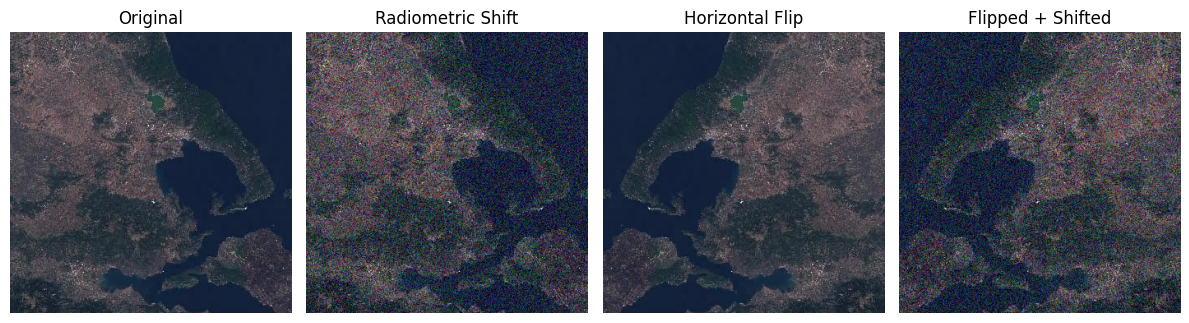

In [9]:
img_path = 'geospatial_data/S2A_MSIL1C_20210925T092031_N0500_R093_T34SFJ_20230118T233535.SAFE/S2A_MSIL1C_20210925T092031_N0500_R093_T34SFJ_20230118T233535-ql.jpg'
img = Image.open(img_path).convert('RGB')

to_tensor = T.ToTensor()
img_tensor = to_tensor(img)

radiometric_shift = RandomRadiometricShift(scale=0.2)
horizontal_flip = T.RandomHorizontalFlip(p=1.0)
random_applier = RandomApplyTransform(radiometric_shift, p=1.0) 

shifted = radiometric_shift(img_tensor)
flipped = horizontal_flip(img_tensor)
applied_random = random_applier(flipped)

def show_image(tensor, title):
    np_img = tensor.permute(1, 2, 0).clamp(0, 1).numpy()
    plt.imshow(np_img)
    plt.title(title)
    plt.axis('off')

plt.figure(figsize=(12, 4))

plt.subplot(1, 4, 1)
show_image(img_tensor, "Original")

plt.subplot(1, 4, 2)
show_image(shifted, "Radiometric Shift")

plt.subplot(1, 4, 3)
show_image(flipped, "Horizontal Flip")

plt.subplot(1, 4, 4)
show_image(applied_random, "Flipped + Shifted")

plt.tight_layout()
plt.savefig("augments.png", dpi=300)
plt.show()